# Regression Week 4: Ridge Regression (gradient descent)

In this notebook, you will implement ridge regression via gradient descent. You will:
* Convert an SFrame into a Numpy array
* Write a Numpy function to compute the derivative of the regression weights with respect to a single feature
* Write gradient descent function to compute the regression weights given an initial weight vector, step size, tolerance, and L2 penalty

# Fire up graphlab create

Make sure you have the latest version of GraphLab Create (>= 1.7)

In [1]:
import graphlab

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [2]:
sales = graphlab.SFrame('kc_house_data.gl/')

This non-commercial license of GraphLab Create for academic use is assigned to dxiao@bloomu.edu and will expire on April 02, 2020.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\danqi\AppData\Local\Temp\graphlab_server_1559171020.log.0


If we want to do any "feature engineering" like creating new features or adjusting existing ones we should do this directly using the SFrames as seen in the first notebook of Week 2. For this notebook, however, we will work with the existing features.

# Import useful functions from previous notebook

As in Week 2, we convert the SFrame into a 2D Numpy array. Copy and paste `get_numpy_data()` from the second notebook of Week 2.

In [3]:
import numpy as np # note this allows us to refer to numpy as np instead 

In [4]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # add a constant column to an SFrame
    # prepend variable 'constant' to the features list
    features = ['constant'] + features
    # select the columns of data_SFrame given by the ‘features’ list into the SFrame ‘features_sframe’
    
    features_sframe=data_sframe[features]
    
    # this will convert the features_sframe into a numpy matrix with GraphLab Create >= 1.7!!
    features_matrix = features_sframe.to_numpy()
    # assign the column of data_sframe associated with the target to the variable ‘output_sarray’
    output_sarray=data_sframe[output]
    # this will convert the SArray into a numpy array:
    output_array = output_sarray.to_numpy() # GraphLab Create>= 1.7!!
    return(features_matrix, output_array)


Also, copy and paste the `predict_output()` function to compute the predictions for an entire matrix of features given the matrix and the weights:

In [8]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    predictions=np.dot(feature_matrix,weights)
    return(predictions)

# Computing the Derivative

We are now going to move to computing the derivative of the regression cost function. Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output, plus the L2 penalty term.
```
Cost(w)
= SUM[ (prediction - output)^2 ]
+ l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2).
```

Since the derivative of a sum is the sum of the derivatives, we can take the derivative of the first part (the RSS) as we did in the notebook for the unregularized case in Week 2 and add the derivative of the regularization part.  As we saw, the derivative of the RSS with respect to `w[i]` can be written as: 
```
2*SUM[ error*[feature_i] ].
```
The derivative of the regularization term with respect to `w[i]` is:
```
2*l2_penalty*w[i].
```
Summing both, we get
```
2*SUM[ error*[feature_i] ] + 2*l2_penalty*w[i].
```
That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself, plus `2*l2_penalty*w[i]`. 

**We will not regularize the constant.**  Thus, in the case of the constant, the derivative is just twice the sum of the errors (without the `2*l2_penalty*w[0]` term).

Recall that twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors, plus `2*l2_penalty*w[i]`.

With this in mind complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points).  To decide when to we are dealing with the constant (so we don't regularize it) we added the extra parameter to the call `feature_is_constant` which you should set to `True` when computing the derivative of the constant and `False` otherwise.

In [29]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    # If feature_is_constant is True, derivative is twice the dot product of errors and feature
    
    if feature_is_constant==True:
        derivative=2*np.dot(errors,feature)
    # Otherwise, derivative is twice the dot product plus 2*l2_penalty*weight
    else:
        derivative=2*(np.dot(errors,feature)+2*l2_penalty*weight).sum()
    return derivative

To test your feature derivartive run the following:

In [30]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price') 
my_weights = np.array([1., 10.])
test_predictions = predict_output(example_features, my_weights) 
errors = test_predictions - example_output # prediction errors

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features[:,1], my_weights[1], 1, False)
print np.sum(errors*example_features[:,1])*2+20.
print ''

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features[:,0], my_weights[0], 1, True)
print np.sum(errors)*2.

-5.65541667823e+13
-5.65541667824e+13

-22446749336.0
-22446749336.0


# Gradient Descent

Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of *increase* and therefore the negative gradient is the direction of *decrease* and we're trying to *minimize* a cost function. 

The amount by which we move in the negative gradient *direction*  is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. Unlike in Week 2, this time we will set a **maximum number of iterations** and take gradient steps until we reach this maximum number. If no maximum number is supplied, the maximum should be set 100 by default. (Use default parameter values in Python.)

With this in mind, complete the following gradient descent function below using your derivative function above. For each step in the gradient descent, we update the weight for each feature before computing our stopping criteria.

In [253]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations):
    print 'Starting gradient descent with l2_penalty = ' + str(l2_penalty)
    
    weights = initial_weights # make sure it's a numpy array
    iteration = 0 # iteration counter
    print_frequency = 1  # for adjusting frequency of debugging output
    
    cost=[1e50]
    #while not reached maximum number of iterations:
    while iteration<max_iterations: 
        predictions=predict_output(feature_matrix, weights)
        errors = predictions - output
        iteration += 1  # increment iteration counter
        ### === code section for adjusting frequency of debugging output. ===
        if iteration == 10:
            print_frequency = 10
        if iteration == 100:
            print_frequency = 100
        if iteration%print_frequency==0:
            print('Iteration = ' + str(iteration))
        ### === end code section ===
        if iteration%print_frequency==0:
            print 'Cost function = ', str(np.dot(errors,errors) + l2_penalty*(np.dot(weights,weights) - weights[0]**2))
        
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        ctemp=np.dot(errors,errors) + l2_penalty*(np.dot(weights,weights) - weights[0]**2)       
               
        if ctemp<=cost[-1]:
            for i in xrange(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
                
                feature = feature_matrix[:,i] 
                if len(feature)==1:
                    feature_is_constant=True
                else:
                    feature_is_constant=False
                if i==0:
                    derivative=2*errors.sum()
                else:                
                    derivative = feature_derivative_ridge(errors, feature, weights, l2_penalty, feature_is_constant)
            #(Remember: when i=0, you are computing the derivative of the constant!)
            # subtract the step size times the derivative from the current weight
                weights[i]=weights[i]-step_size*derivative
            
            cost.append(ctemp)
            
        else:
            break
            
            
            
    print 'Done with gradient descent at iteration ', iteration
    print 'Learned weights = ', str(weights)
    print cost
    return weights

# Visualizing effect of L2 penalty

The L2 penalty gets its name because it causes weights to have small L2 norms than otherwise. Let's see how large weights get penalized. Let us consider a simple model with 1 feature:

In [86]:
simple_features = ['sqft_living']
my_output = 'price'

Let us split the dataset into training set and test set. Make sure to use `seed=0`:

In [150]:
train_data,test_data = sales.random_split(.8,seed=0)

In this part, we will only use `'sqft_living'` to predict `'price'`. Use the `get_numpy_data` function to get a Numpy versions of your data with only this feature, for both the `train_data` and the `test_data`. 

In [151]:
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

Let's set the parameters for our optimization:

In [245]:
initial_weights = np.array([0., 0.])
print len(initial_weights)
step_size = 1e-12
max_iterations=1000
l2_penalty=0

2


First, let's consider no regularization.  Set the `l2_penalty` to `0.0` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`simple_weights_0_penalty`

we'll use them later.

In [254]:
simple_weights_0_penalty=ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations)

Starting gradient descent with l2_penalty = 0
Iteration = 1
Cost function =  2.25318801037e+15
Iteration = 2
Cost function =  1.63637787619e+15
Iteration = 3
Cost function =  1.38366125697e+15
Iteration = 4
Cost function =  1.28011936278e+15
Iteration = 5
Cost function =  1.23769665275e+15
Iteration = 6
Cost function =  1.22031541452e+15
Iteration = 7
Cost function =  1.21319405328e+15
Iteration = 8
Cost function =  1.21027632176e+15
Iteration = 9
Cost function =  1.20908088215e+15
Iteration = 10
Cost function =  1.20859109207e+15
Iteration = 20
Cost function =  1.20825117435e+15
Iteration = 30
Cost function =  1.20825112831e+15
Iteration = 40
Cost function =  1.20825112759e+15
Iteration = 50
Cost function =  1.20825112686e+15
Iteration = 60
Cost function =  1.20825112614e+15
Iteration = 70
Cost function =  1.20825112542e+15
Iteration = 80
Cost function =  1.20825112469e+15
Iteration = 90
Cost function =  1.20825112397e+15
Iteration = 100
Cost function =  1.20825112325e+15
Iteration = 

Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`simple_weights_high_penalty`

we'll use them later.

In [255]:
initial_weights = np.array([0., 0.])
print len(initial_weights)
step_size = 1e-12
max_iterations=1000
l2_penalty_h=1e11
simple_weights_high_penalty=ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, l2_penalty_h, max_iterations)

2
Starting gradient descent with l2_penalty = 1e+11
Iteration = 1
Cost function =  7.43305185103e+15
Iteration = 2
Cost function =  4.65487992621e+15
Iteration = 3
Cost function =  4.49468510438e+15
Iteration = 4
Cost function =  4.48542815495e+15
Iteration = 5
Cost function =  4.48488697985e+15
Iteration = 6
Cost function =  4.48485346654e+15
Iteration = 7
Cost function =  4.48485084644e+15
Iteration = 8
Cost function =  4.48485049097e+15
Iteration = 9
Cost function =  4.48485040979e+15
Iteration = 10
Cost function =  4.48485039099e+15
Done with gradient descent at iteration  11
Learned weights =  [  1.09311751e-01   1.24518014e+02]
[1e+50, 7433051851026171.0, 4654879926212546.0, 4494685104382835.0, 4485428154945341.0, 4484886979849796.0, 4484853466541878.5, 4484850846435538.0, 4484850490965896.0, 4484850409787939.0, 4484850390994695.0]


This code will plot the two learned models.  (The blue line is for the model with no regularization and the red line is for the one with high regularization.)

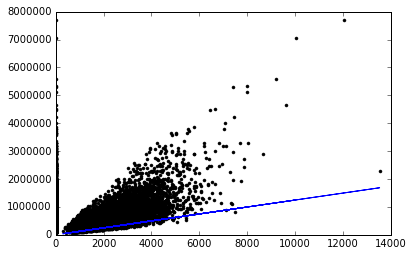

In [155]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(simple_feature_matrix,output,'k.',
         simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_0_penalty),'b-')

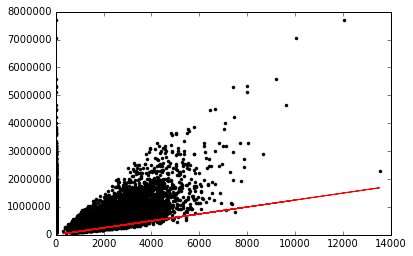

In [156]:
plt.plot(simple_feature_matrix,output,'k.',simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_high_penalty),'r-')

Compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Which weights perform best?

In [193]:
initial_weights = np.array([0., 0.])
predictions1=predict_output(simple_test_feature_matrix,initial_weights)
print predictions1
errors = (predictions1 -test_output)**2
print errors.sum()

[ 0.  0.  0. ...,  0.  0.  0.]
1.78427328252e+15


In [194]:
predictions2=predict_output(simple_test_feature_matrix,simple_weights_0_penalty)
print simple_weights_0_penalty
print predictions2
errors2 = (predictions2 -test_output)**2
print errors2.sum()

[ -2.15963990e-01   2.63024390e+02]
[ 376124.66237345  775921.73585101  449771.49169827 ...,  662821.24795933
  607586.12596572  268284.66229069]
2.75723632555e+14


In [195]:
predictions3=predict_output(simple_test_feature_matrix,simple_weights_high_penalty)
print simple_weights_high_penalty
print predictions3
errors3 = (predictions3 -test_output)**2
print errors3.sum()

[  1.09311751e-01   1.24518014e+02]
[ 178060.86920074  367328.25034148  212925.91309509 ...,  313785.50436088
  287636.72144012  127008.4834983 ]
6.94992355694e+14


***QUIZ QUESTIONS***
1. What is the value of the coefficient for `sqft_living` that you learned with no regularization, rounded to 1 decimal place?  What about the one with high regularization?
2. Comparing the lines you fit with the with no regularization versus high regularization, which one is steeper?
3. What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)? 


# Running a multiple regression with L2 penalty

Let us now consider a model with 2 features: `['sqft_living', 'sqft_living15']`.

First, create Numpy versions of your training and test data with these two features. 

In [209]:
model_features = ['sqft_living', 'sqft_living15'] # sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)

We need to re-inialize the weights, since we have one extra parameter. Let us also set the step size and maximum number of iterations.

In [256]:
initial_weights = np.array([0.0,0.0,0.0])
step_size = 1e-12
max_iterations = 1000

First, let's consider no regularization.  Set the `l2_penalty` to `0.0` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`multiple_weights_0_penalty`

In [257]:
l2_penalty_l =0.0
multiple_weights_0_penalty=ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty_l, max_iterations)

Starting gradient descent with l2_penalty = 0.0
Iteration = 1
Cost function =  7.43305185103e+15
Iteration = 2
Cost function =  1.27060580122e+15
Iteration = 3
Cost function =  1.26651782148e+15
Iteration = 4
Cost function =  1.26436880349e+15
Iteration = 5
Cost function =  1.26229612955e+15
Iteration = 6
Cost function =  1.26029656476e+15
Iteration = 7
Cost function =  1.25836753019e+15
Iteration = 8
Cost function =  1.25650653805e+15
Iteration = 9
Cost function =  1.2547111883e+15
Iteration = 10
Cost function =  1.25297916553e+15
Iteration = 20
Cost function =  1.23868739166e+15
Iteration = 30
Cost function =  1.22870737118e+15
Iteration = 40
Cost function =  1.22173827054e+15
Iteration = 50
Cost function =  1.21687171089e+15
Iteration = 60
Cost function =  1.21347336654e+15
Iteration = 70
Cost function =  1.21110028459e+15
Iteration = 80
Cost function =  1.20944314869e+15
Iteration = 90
Cost function =  1.20828596166e+15
Iteration = 100
Cost function =  1.20747789152e+15
Iteration =

Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`multiple_weights_high_penalty`

In [258]:
initial_weights = np.array([0.0,0.0,0.0])
step_size = 1e-12
max_iterations = 1000
l2_penalty_h =1e11
multiple_weights_high_penalty=ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty_h, max_iterations)

Starting gradient descent with l2_penalty = 1e+11
Iteration = 1
Cost function =  7.43305185103e+15
Iteration = 2
Cost function =  4.0359948934e+15
Iteration = 3
Cost function =  3.98847313427e+15
Iteration = 4
Cost function =  3.81829886199e+15
Iteration = 5
Cost function =  3.9207091733e+15
Done with gradient descent at iteration  5
Learned weights =  [  3.97457132e-02   1.12051064e+02   3.14741760e+01]
[1e+50, 7433051851026171.0, 4035994893402865.0, 3988473134272352.5, 3818298861991971.5]


Compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Which weights perform best?

In [212]:
initial_weights = np.array([0.0,0.0,0.0])
predictionsm1=predict_output(test_feature_matrix,initial_weights)
print predictionsm1
errorsm1 = (predictionsm1 -test_output)**2
print errorsm1.sum()

[ 0.  0.  0. ...,  0.  0.  0.]
1.78427328252e+15


In [215]:
predictionsm2=predict_output(test_feature_matrix,multiple_weights_0_penalty)
print multiple_weights_0_penalty
print predictionsm2
errorsm2 = (predictionsm2 -test_output)**2
print errorsm2.sum()

[  -0.36692953  243.31658446   22.129868  ]
[ 387333.51387442  765141.47472531  438864.75652511 ...,  668924.69324784
  602558.60159507  270755.01457084]
2.74080549018e+14


In [216]:
predictionsm3=predict_output(test_feature_matrix,multiple_weights_high_penalty)
print multiple_weights_high_penalty
print predictionsm3
errorsm3 = (predictionsm3 -test_output)**2
print errorsm3.sum()

[  3.97457132e-02   1.12051064e+02   3.14741760e+01]
[ 216257.09493195  397905.41593402  224025.76089282 ...,  361683.64520684
  316435.74025656  146395.78481331]
6.03592596653e+14


Predict the house price for the 1st house in the test set using the no regularization and high regularization models. (Remember that python starts indexing from 0.) How far is the prediction from the actual price?  Which weights perform best for the 1st house?

In [217]:
pre_l=predict_output(test_feature_matrix[0],multiple_weights_0_penalty)
print pre_l

387333.513874


In [259]:
pre_h=predict_output(test_feature_matrix[0],multiple_weights_high_penalty)
print pre_h

216257.094932


In [260]:
print test_data['price'][0]
print test_output

310000.0
[ 310000.  650000.  233000. ...,  610685.  400000.  402101.]


***QUIZ QUESTIONS***
1. What is the value of the coefficient for `sqft_living` that you learned with no regularization, rounded to 1 decimal place?  What about the one with high regularization?
2. What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)? 
3. We make prediction for the first house in the test set using two sets of weights (no regularization vs high regularization). Which weights make better prediction <u>for that particular house</u>?

In [206]:
pre_l-310000.0

77333.513874417404

In [208]:
310000-216257.094932

93742.905068